In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy

os.chdir(os.path.join(basedir, 'neuralDDE_ROM_Closure'))

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
import src.cdv_eqn_case.rom_cdv_eqn as rom
from src.cdv_eqn_case.cdv_eqn import cdv_eqn

import time
from math import *
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32')

In [4]:
class initial_cond:

    def __init__(self, app):
        self.app = app

    def __call__(self, t):
        x0 = [self.app.x1_star, 0., 0., self.app.x4_star, 0., 0.]
        return tf.convert_to_tensor([x0], dtype=tf.float32)

In [5]:
app = rom.rom_cdv_eqn_args(T = 160., nt = 320, x1_star = 0.95, x4_star = -0.76095, C = 0.1, beta = 1.25, gamma = 0.2, b = 0.5, rom_dims = 4, rom_batch_size = 1)

x0 = initial_cond(app) # Initial conditions
t = tf.linspace(0., app.T, app.nt) # Time array

x = ddeinttf(cdv_eqn(app), x0, t)

print('FOM done!')

FOM done!


In [6]:
x_mean, x_modes = rom.create_mean_modes(tf.squeeze(x, axis=1), app, t)()

ai_t0 = rom.initial_cond_rom(x0, x_modes, x_mean)

In [7]:
ai = ddeinttf(rom.rom_cdv_eqn(xm = x_mean, xi = x_modes, app = app), ai_t0, t)

In [8]:
ai_true = tf.cast(tf.einsum('ab, dca -> dcb', tf.cast(x_modes, tf.float64), tf.cast(x, tf.float64)), tf.float32)

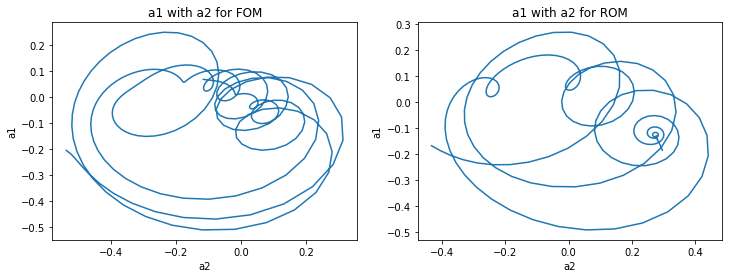

In [9]:
fig = plt.figure(figsize=(12, 4), facecolor='white')
ax_fom = fig.add_subplot(121)
ax_rom = fig.add_subplot(122)

ax_fom.cla()
ax_fom.set_title('a1 with a2 for FOM')
ax_fom.set_xlabel('a2')
ax_fom.set_ylabel('a1')
ax_fom.plot(ai_true[:, 0, 0], ai_true[:, 0, 1])

ax_rom.cla()
ax_rom.set_title('a1 with a2 for ROM')
ax_rom.set_xlabel('a2')
ax_rom.set_ylabel('a1')
ax_rom.plot(ai[:, 0, 0], ai[:, 0, 1])